In [1]:
%cat 0Source_Citation.txt

Source and citation

- This notebook is a part of the `pytheos` package.
- Website: http://github.com/SHDShim/pytheos.
- How to cite: S.-H. Shim (2017) Pytheos - a python tool set for equations of state. DOI: 10.5281/zenodo.802392


In [2]:
%matplotlib inline
# %matplotlib notebook # for interactive

For high dpi displays.

In [3]:
%config InlineBackend.figure_format = 'retina' 

# 0. General note

* This notebook shows an example of EOS fitting for static compression, focusing on converting pressure scales when the volume data for pressure standard is not available.  

* The notebook demonstrates easy ways to change the EOS for pressure standard.

* We use data from [Lundin et al. (2007, PEPI)](http://www.sciencedirect.com/science/article/pii/S0031920108000939).

# 1. Global setup

In [4]:
import numpy as np
from uncertainties import unumpy as unp
import pandas as pd
import pytheos as eos

# 2. Setup pressure scale and starting values

Setup dictionaries for pressure standard `(au_eos)` and equation to use `(fit_model)`.  This allows for eos fits with a wide range of different pressure scales.

In [5]:
au_eos = {'Fei2007': eos.gold.Fei2007bm3(), 'Dorogokupets2007': eos.gold.Dorogokupets2007(),
          'Yokoo2009': eos.gold.Yokoo2009(), 'Ye2017': eos.gold.Ye2017()}
fit_model = {'Fei2007': eos.BM3Model(), 'Dorogokupets2007': eos.VinetModel(),
             'Yokoo2009': eos.BM3Model(), 'Ye2017': eos.VinetModel()}

Lundin et al. (2007) used the gold scale by Tsuchiya (2003).  Since then many updates have been made by a few different authors.

In [6]:
au_org = eos.gold.Tsuchiya2003()

Uncomment the following line to get some help.

In [7]:
#help(eos.gold.Yokoo2009)

We set initial values for the EOS parameters.

In [8]:
v0 = {'en100': 162.30, 'en91': 163.18, 'en85': 163.30}
k0 = {'en100': 260., 'en91': 260., 'en85': 260.}
k0p = {'en100': 4.0, 'en91': 4.0, 'en85': 4.0}

# 3. Setup data

Read data file.  Data points are stored in `csv` files.  

In [9]:
data = pd.read_csv('./data/Lundin2007.csv')

Make error propagation possible.

In [10]:
v = {'en100': unp.uarray(data['v(en100)'][~np.isnan(data['v(en100)'])],
                        data['sv(en100)'][~np.isnan(data['v(en100)'])]),
    'en91': unp.uarray(data['v(en91)'], data['sv(en91)']),
    'en85': unp.uarray(data['v(en85)'], data['sv(en85)'])}
p_org= {'en100': unp.uarray(data['p(en100)'][~np.isnan(data['v(en100)'])], 
                            data['sp(en100)'][~np.isnan(data['v(en100)'])]),
    'en91': unp.uarray(data['p(en91)'], data['sp(en91)']),
    'en85': unp.uarray(data['p(en85)'], data['sp(en85)'])}
v_std= {}

# 4. Fit with the original pressure scale

In order to understand the cell below, please try the `8_pv_eos_fit_multi-scales.ipynb` file first.

***en100
[[Model]]
    Model(bm3_p)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 16
    # variables        = 1
    chi-square         = 24.8394521
    reduced chi-square = 1.65596347
    Akaike info crit   = 9.03751161
    Bayesian info crit = 9.81010034
[[Variables]]
    v0:   162.3 (fixed)
    k0:   263.389033 +/- 1.45857729 (0.55%) (init = 260)
    k0p:  4 (fixed)

***en91
[[Model]]
    Model(bm3_p)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 17
    # variables        = 1
    chi-square         = 6.73580735
    reduced chi-square = 0.42098796
    Akaike info crit   = -13.7381864
    Bayesian info crit = -12.9049730
[[Variables]]
    v0:   163.18 (fixed)
    k0:   257.839699 +/- 0.73597550 (0.29%) (init = 260)
    k0p:  4 (fixed)

***en85
[[Model]]
    Model(bm3_p)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      =

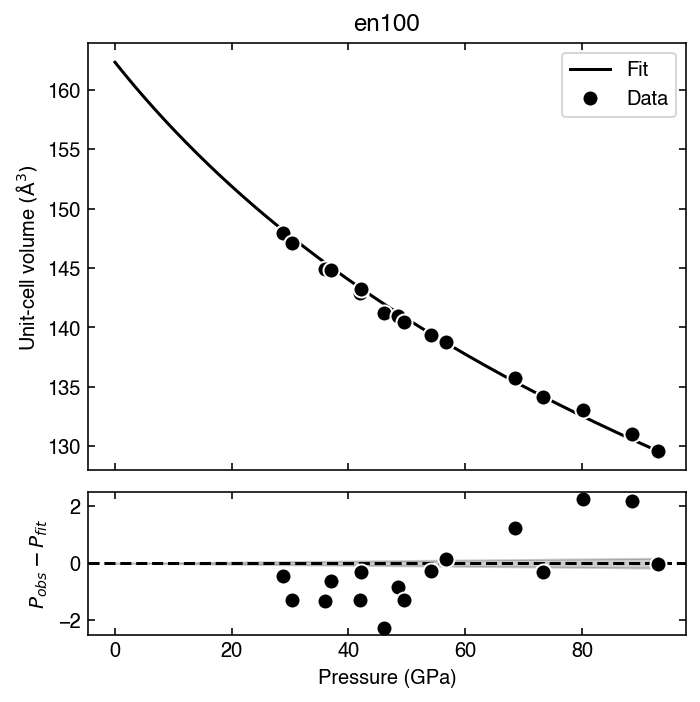

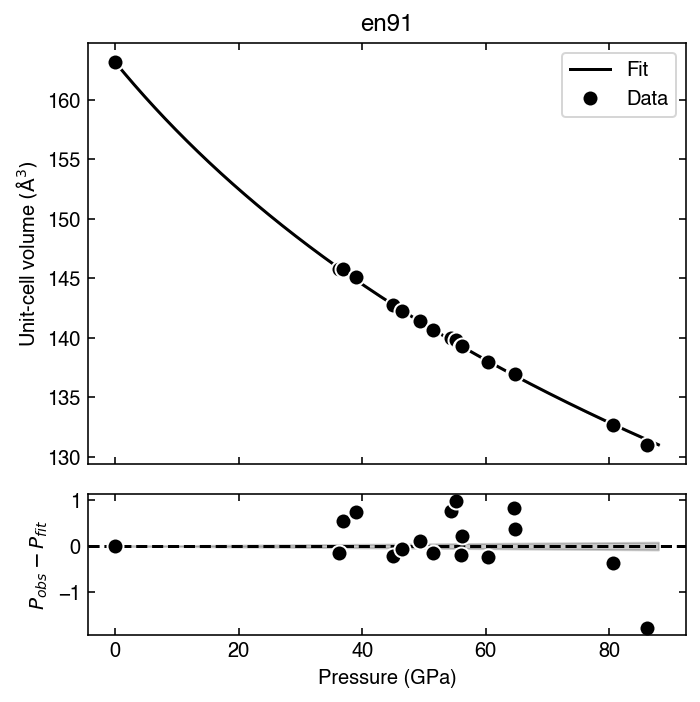

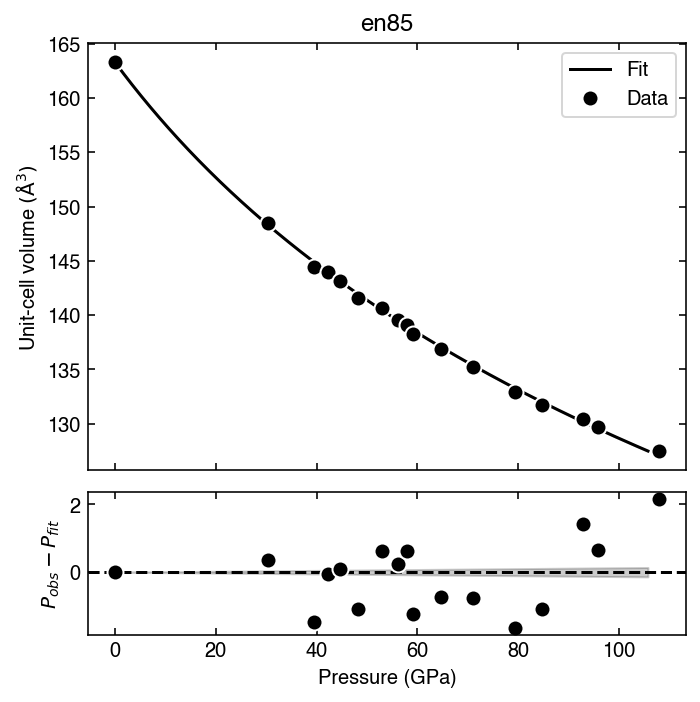

In [11]:
for key, value in v.items():
    model = eos.BM3Model()
    params = model.make_params(v0=v0[key], k0=k0[key], k0p=k0p[key])
    params['v0'].vary = False
    params['k0p'].vary = False
    fitresult = model.fit(unp.nominal_values(p_org[key]), params, v=unp.nominal_values(v[key]))
    print('***'+key)
    print(fitresult.fit_report())
    eos.plot.static_fit_result(fitresult, title=key)

# 5. Recover the volume of pressure standard

In order to convert to different gold scale, we first invert the equation to get volume from pressure.  The cell below iteratively perform this task for all three different compositions in Lundin et al.

In [12]:
for key, value in p_org.items():
    p_tempo = unp.nominal_values(value)
    # filter out empty cells
    p_norm = p_tempo[~np.isnan(p_tempo)]
    # now we get volume of gold
    v_std[key] = au_org.cal_v(p_norm,
                             np.ones_like(p_norm) * 300.)

# 6. Fit for different pressure scales

We fix `v0` and `k0p` in this fitting example

***Fei2007 en100
[[Model]]
    Model(bm3_p)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 16
    # variables        = 1
    chi-square         = 21.3661256
    reduced chi-square = 1.42440837
    Akaike info crit   = 6.62748848
    Bayesian info crit = 7.40007721
[[Variables]]
    v0:   162.3 (fixed)
    k0:   258.324402 +/- 1.35276181 (0.52%) (init = 260)
    k0p:  4 (fixed)

***Dorogokupets2007 en100
[[Model]]
    Model(vinet_p)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 16
    # variables        = 1
    chi-square         = 22.0942768
    reduced chi-square = 1.47295178
    Akaike info crit   = 7.16367812
    Bayesian info crit = 7.93626685
[[Variables]]
    v0:   162.3 (fixed)
    k0:   260.178430 +/- 1.38729624 (0.53%) (init = 260)
    k0p:  4 (fixed)

***Yokoo2009 en100
[[Model]]
    Model(bm3_p)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function 

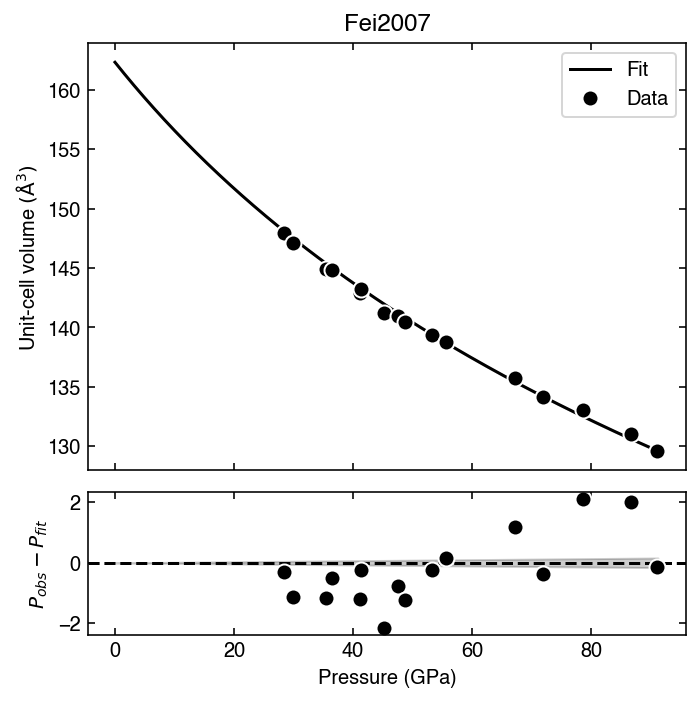

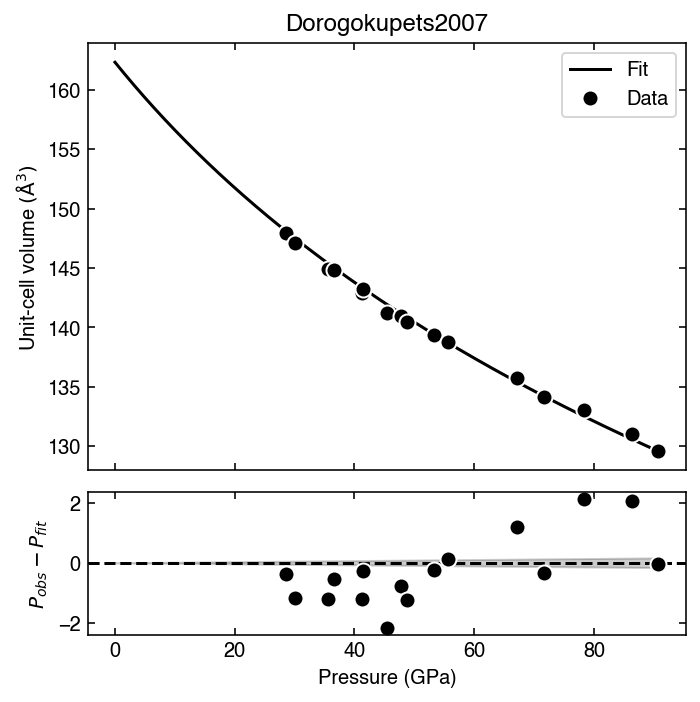

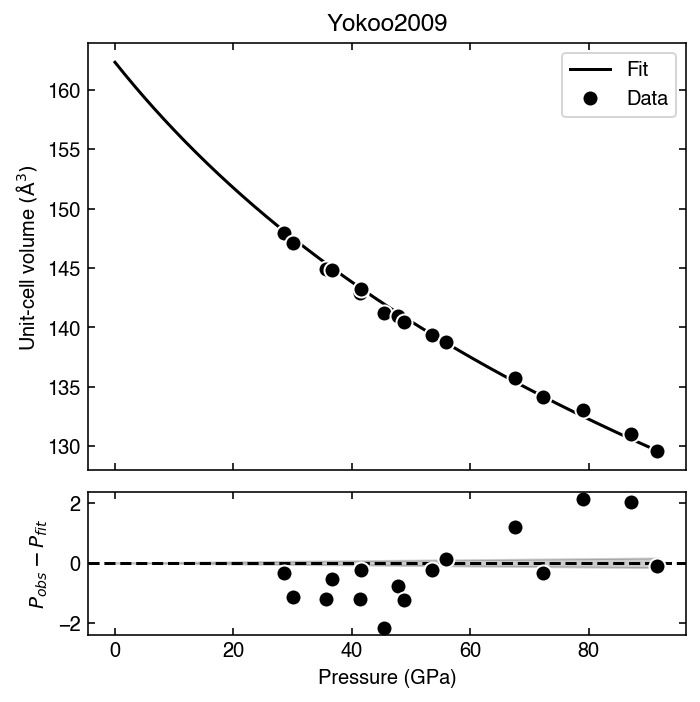

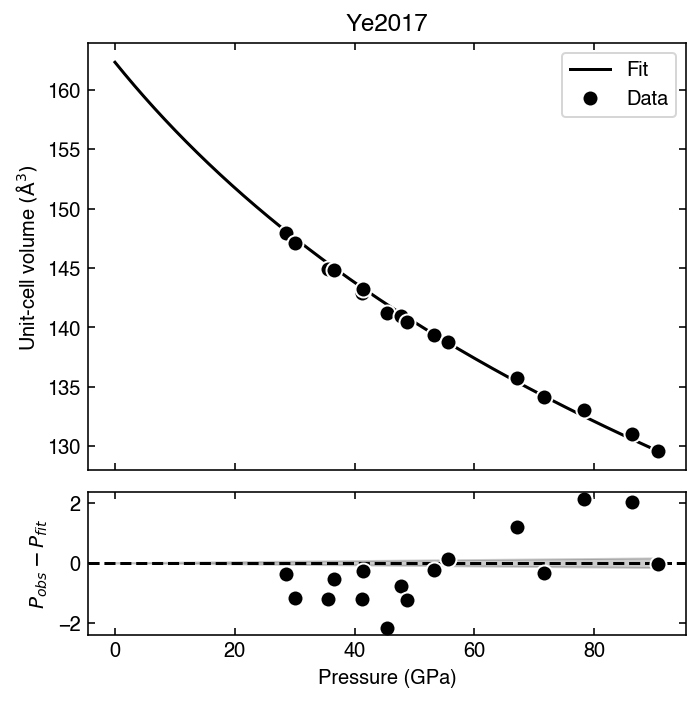

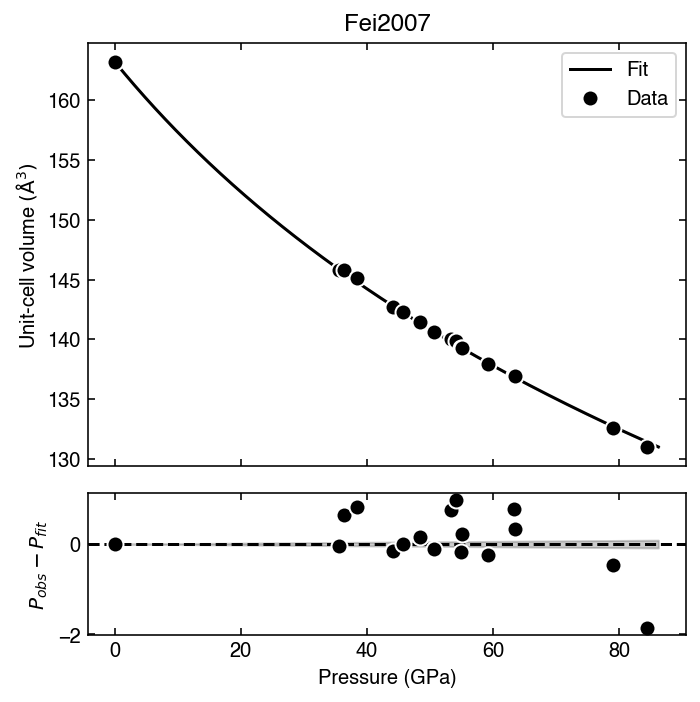

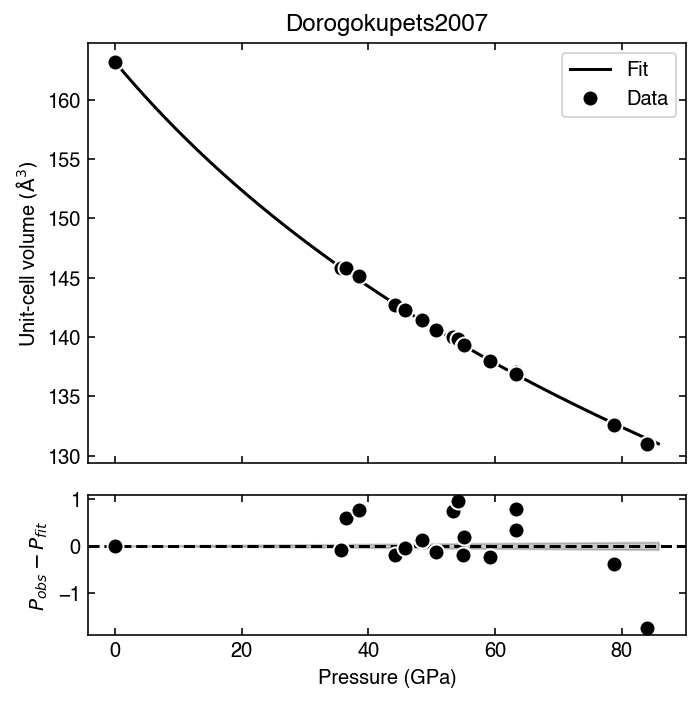

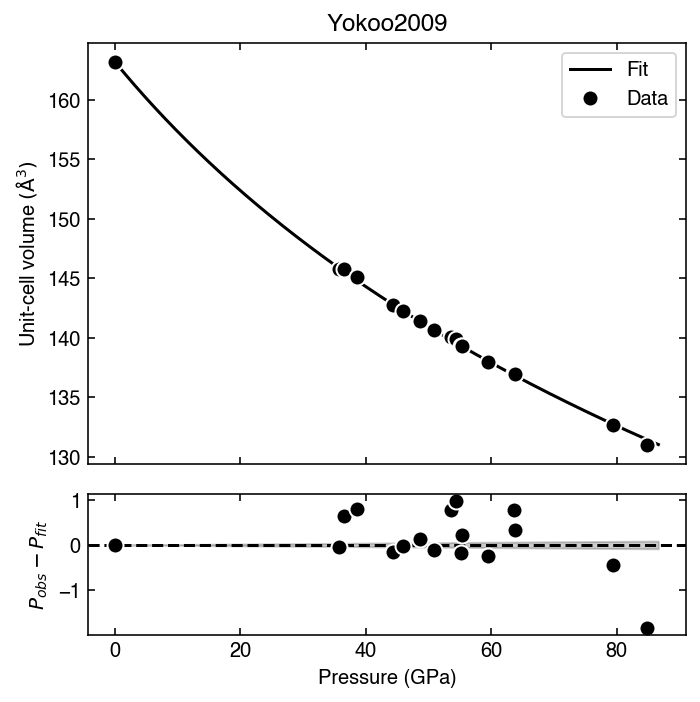

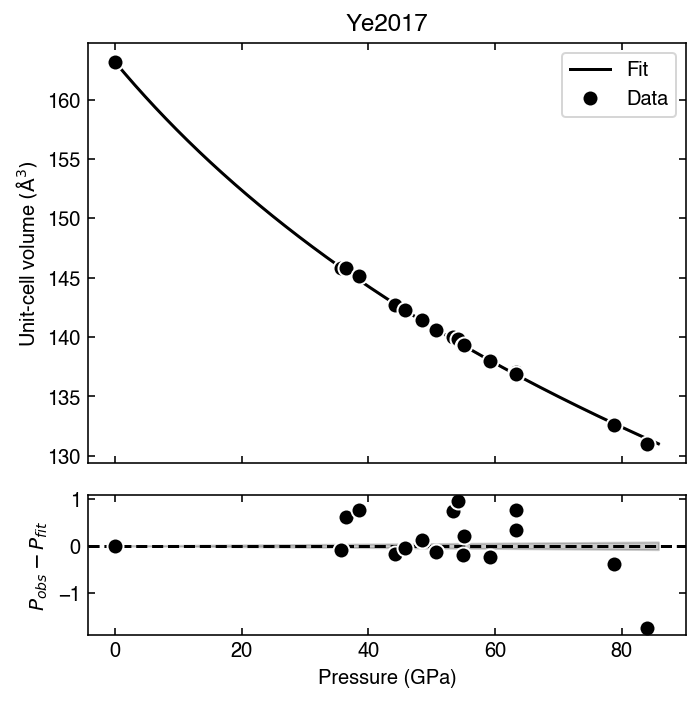

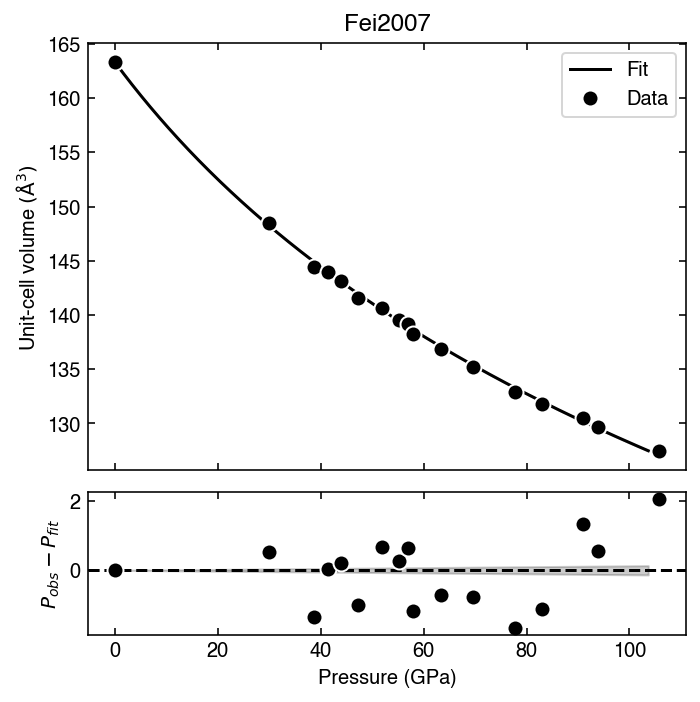

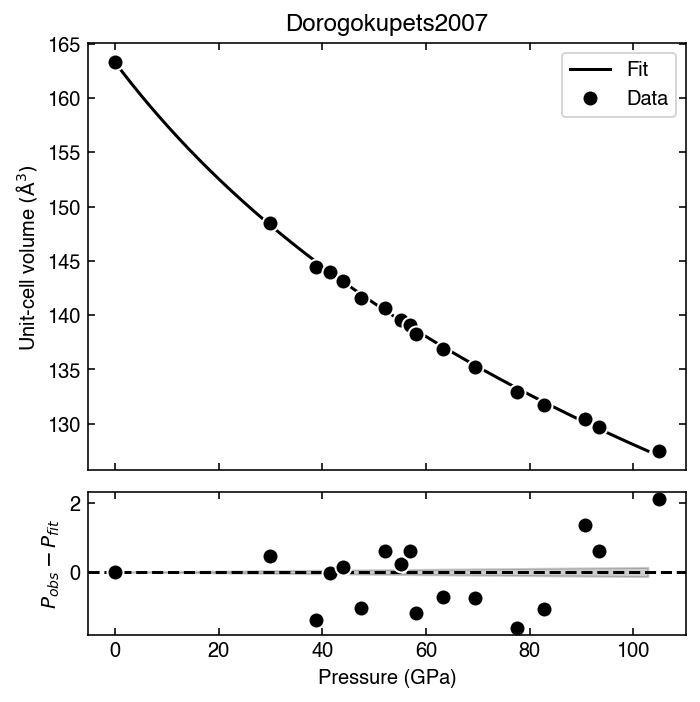

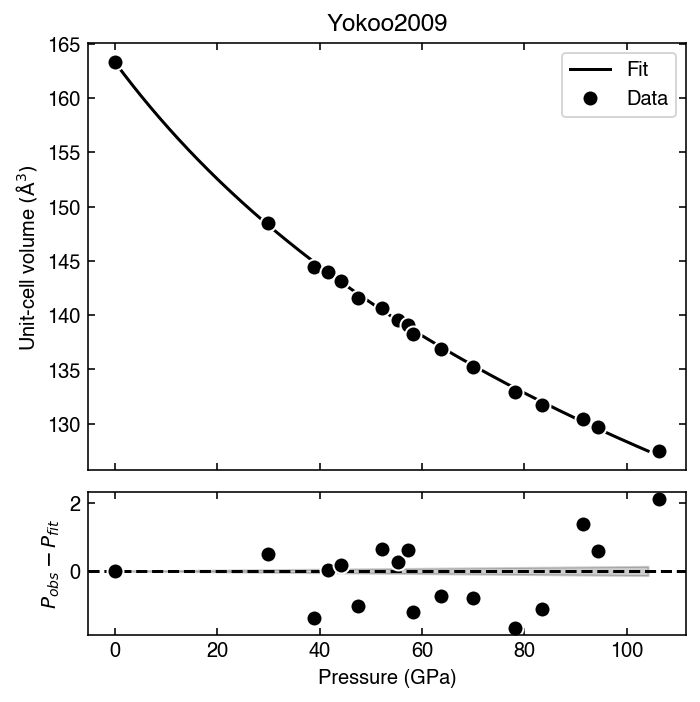

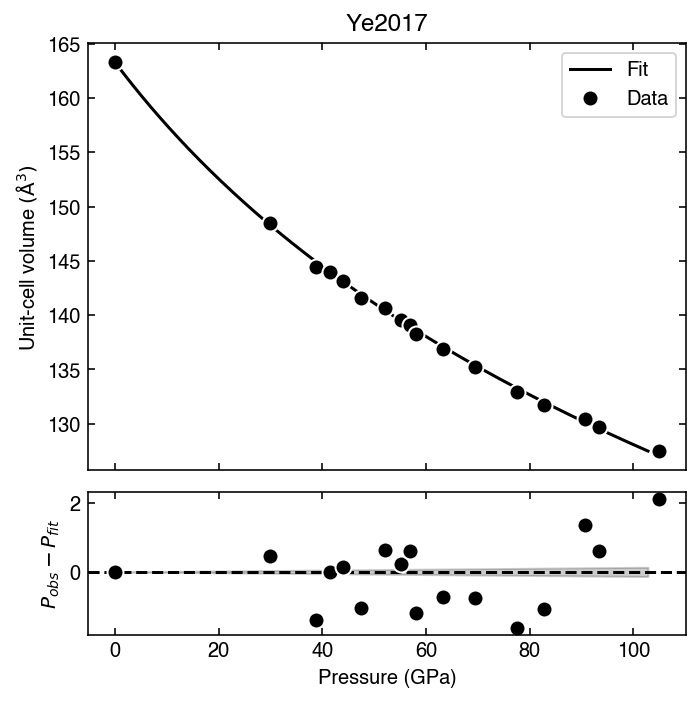

In [13]:
for comp, value in v.items(): # iteration for different compositions
    for key, value in au_eos.items(): # iteration for different gold scales
        # set pressure scale to use
        p = au_eos[key].cal_pst(v_std[comp])
        # set equation to use
        model = fit_model[key]
        params = model.make_params(v0=v0[comp], k0=k0[comp], k0p=k0p[comp])
        params['v0'].vary = False
        params['k0p'].vary = False
        # perform fitting
        fitresult = model.fit(unp.nominal_values(p), params, v=unp.nominal_values(v[comp]))
        print('***'+key+' '+comp)
        print(fitresult.fit_report())
        eos.plot.static_fit_result(fitresult, title=key)